In [1]:
import os
import sys
import json
import pandas as pd
import numpy as np
import h5py
from collections import defaultdict
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans, KernelKMeans, KShape

dataset_path = r"C:\Users\lhauptmann\Code\WristPPG2\data\dataset"

In [2]:
def center_signal(signal, start_idx, end_idx):

    window_signal = signal[start_idx:end_idx]
    centroid = (window_signal * np.arange(len(window_signal))).sum() / window_signal.sum()
    shift = centroid - len(window_signal) / 2
    
    return shift
    
    

In [3]:
def import_hdf5_session(file_path, fixed_length:int=None):
    samples = []
    with h5py.File(file_path, 'r') as f:
        data_dict = f["data"]
        
        acc_mag = np.sqrt(data_dict["acc_x"][:]**2 + data_dict["acc_y"][:]**2 + data_dict["acc_z"][:]**2)
        acc_mag_abs = np.abs((acc_mag - np.mean(acc_mag)) / np.std(acc_mag))
        for key in f.keys():
            if key != "data":
                start_index = f[key]["start_index"][()]
                end_index = f[key]["end_index"][()]
                if start_index == end_index:
                    continue
                shift = int(center_signal(acc_mag_abs, start_index, end_index))
                shift = min(max(shift, -start_index), len(acc_mag_abs) - end_index)
                shift=0
                start_index += shift
                end_index += shift
                
                sample = {}
            
                for modality in data_dict.keys():
                    sample[modality] = data_dict[modality][start_index:end_index]
                    #sample[modality] = (sample[modality] - np.mean(sample[modality])) / np.std(sample[modality])
                    if fixed_length and end_index - start_index < fixed_length:
                        pad_start = (fixed_length - (end_index - start_index)) // 2
                        pad_end = fixed_length - (end_index - start_index) - pad_start
                        sample[modality] = np.pad(sample[modality], (pad_start, pad_end), "constant")
                    elif fixed_length and end_index - start_index > fixed_length:
                        cut_start = (end_index - start_index - fixed_length) // 2
                        cut_end = end_index - start_index - fixed_length - cut_start
                        sample[modality] = sample[modality][cut_start:-cut_end]
                        
                    
                    
                sample["participant"] = os.path.basename(file_path).split("_")[1]
                sample["session"] = os.path.basename(file_path).split("_")[2].replace(".hdf5", "")
                sample["label"] = key.split("_")[0]
                
                samples.append(sample)
    return samples


def import_hdf5_sequences(file_path,):
    sample = {}
    with h5py.File(file_path, 'r') as f:
        
        data_dict = f["data"]
        for key in data_dict:
            sample[key] = data_dict[key][:]  
                    
        sample["participant"] = os.path.basename(file_path).split("_")[1]
        sample["session"] = os.path.basename(file_path).split("_")[2].replace(".hdf5", "")
        sample["label"] = [el.split("_")[0] for el in f.keys() if el != "data"]
        sample["label_times"] = [(f[key]["start_time"][()], f[key]["end_time"][()]) for key in f.keys() if key != "data"]
        sample["label_indices"] = [(f[key]["start_index"][()], f[key]["end_index"][()]) for key in f.keys() if key != "data"]
        sample["timestamp"] = [el.split("_")[1] for el in f.keys() if el != "data"]
    return sample

def save_hd5f_sequence(file_path, sample, overwrite=False):
    if not overwrite:
        assert not os.path.exists(file_path), "File already exists"
    with h5py.File(file_path, 'w') as f:
        data_dict = f.create_group("data")
        for key in sample:
            if key == "participant" or key == "session" or key == "label" or key == "label_times" or key == "label_indices" or key == "timestamp":
                continue
            data_dict.create_dataset(key, data=sample[key])
        for i, label in enumerate(sample["label"]):
            label_group = f.create_group(label + "_{}".format(sample["timestamp"][i]))
            label_group.create_dataset("start_time", data=sample["label_times"][i][0])
            label_group.create_dataset("end_time", data=sample["label_times"][i][1])
            label_group.create_dataset("start_index", data=sample["label_indices"][i][0])
            label_group.create_dataset("end_index", data=sample["label_indices"][i][1])
            label_group.create_dataset("label", data=label)
            
    print("Saved to {}".format(file_path))
                
all_participants = [el for el in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, el))]  
all_files = []
for participant in all_participants:
    participant_path = os.path.join(dataset_path, participant)
    if "exp" in participant or "ppg" in participant:
        continue
    
    all_files += [os.path.join(participant_path, file) for file in os.listdir(participant_path)]       
    



In [4]:
def signal_energy(signal):
    return np.sum(signal ** 2)

def signal_mean(signal):
    return np.mean(signal)

def signal_std(signal):
    return np.std(signal)

def centeredness(signal):
    signal_normalized = np.abs((signal - signal.mean()) / signal.std())
    centroid = (signal_normalized * np.arange(len(signal_normalized))).sum() / signal_normalized.sum()
    return centroid - len(signal_normalized) / 2

def abs_std(signal):
    signal_normalized = np.abs((signal - signal.mean()) / signal.std())
    return np.std(np.abs(signal_normalized))


def compute_magnitudes(samples):
    if "acc_x" in samples[0].keys() and "acc_y" in samples[0].keys() and "acc_z" in samples[0].keys():
        for sample in samples:
            sample["acc"] = np.sqrt(sample["acc_x"] ** 2 + sample["acc_y"] ** 2 + sample["acc_z"] ** 2)
    
    if "gyro_x" in samples[0].keys() and "gyro_y" in samples[0].keys() and "gyro_z" in samples[0].keys():
        for sample in samples:
            sample["gyro"] = np.sqrt(sample["gyro_x"] ** 2 + sample["gyro_y"] ** 2 + sample["gyro_z"] ** 2)
        
    if "acc_ppg_x" in samples[0].keys() and "acc_ppg_y" in samples[0].keys() and "acc_ppg_z" in samples[0].keys():
        for sample in samples:
            sample["acc_ppg"] = np.sqrt(sample["acc_ppg_x"] ** 2 + sample["acc_ppg_y"] ** 2 + sample["acc_ppg_z"] ** 2)
        
    return samples


def compute_derivitatives(samples):
    for sample in samples:
        keys = list(sample.keys())
        for key in keys:
            if key in ["acc", "gyro", "acc_ppg"]:
                sample[key + "_diff"] = np.diff(sample[key])
    return samples

metrics = {
    "energy": signal_energy,
    "mean": signal_mean,
    "std": signal_std,
    "centeredness": centeredness,
    "abs_std": abs_std
}

In [57]:
sample_dict = defaultdict(list)

samples = []

for file in all_files[:200]:

    sample = import_hdf5_session(file, fixed_length=None)
    sample = compute_magnitudes(sample)
    sample = compute_derivitatives(sample)
    samples += sample

for i, sample in enumerate(samples):
    
    sample_dict["participant"].append(sample["participant"])
    sample_dict["session"].append(sample["session"])
    sample_dict["label"].append(sample["label"])
    for modality in sample.keys():
        if modality in ["participant", "session", "label", "timestamp", "package_id"] or "ppg_amb" in modality:
            continue
        for metric_name, metric in metrics.items():
            sample_dict[f"{modality}_{metric_name}"].append(metric(sample[modality]))
    sample_dict["id"].append(i)
sample_df = pd.DataFrame(sample_dict)

sample_df["label_id"] = sample_df["label"].astype("category").cat.codes
sample_df["participant_id"] = sample_df["participant"].astype("category").cat.codes

C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_6684\3079500520.py:11: RuntimeWarning: invalid value encountered in divide
  signal_normalized = np.abs((signal - signal.mean()) / signal.std())
C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_6684\3079500520.py:16: RuntimeWarning: invalid value encountered in divide
  signal_normalized = np.abs((signal - signal.mean()) / signal.std())


<Axes: >

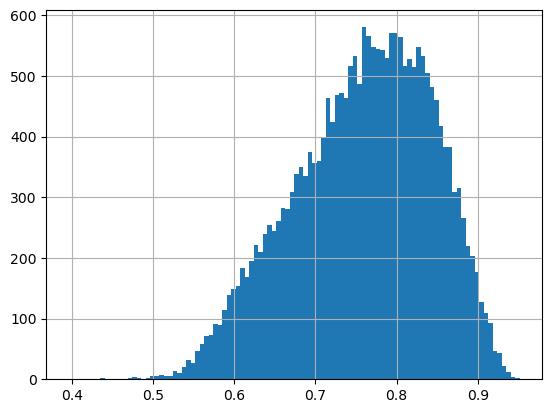

In [58]:
sample_df["acc_abs_std"].hist(bins=100)

<Axes: >

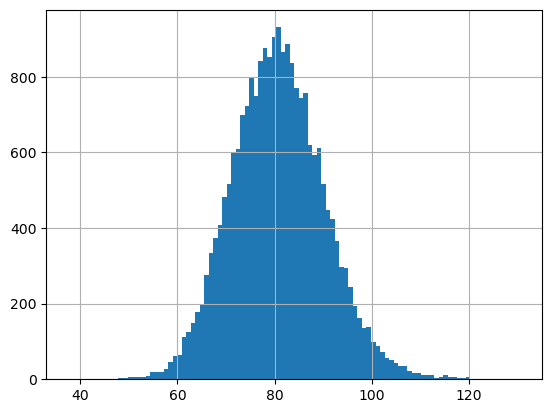

In [44]:
sample_df["acc_centroid_wieghted"].hist(bins=100)

<Axes: >

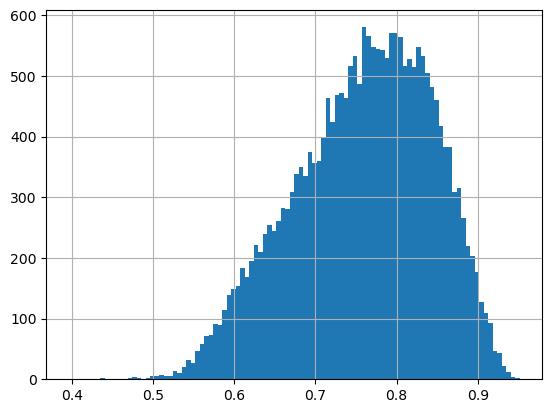

In [75]:
sample_df["acc_abs_std"].hist(bins=100)

C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_6684\3345969912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_samples["sort_value"] = filtered_samples["acc_centeredness"].abs() * filtered_samples["acc_abs_std"]


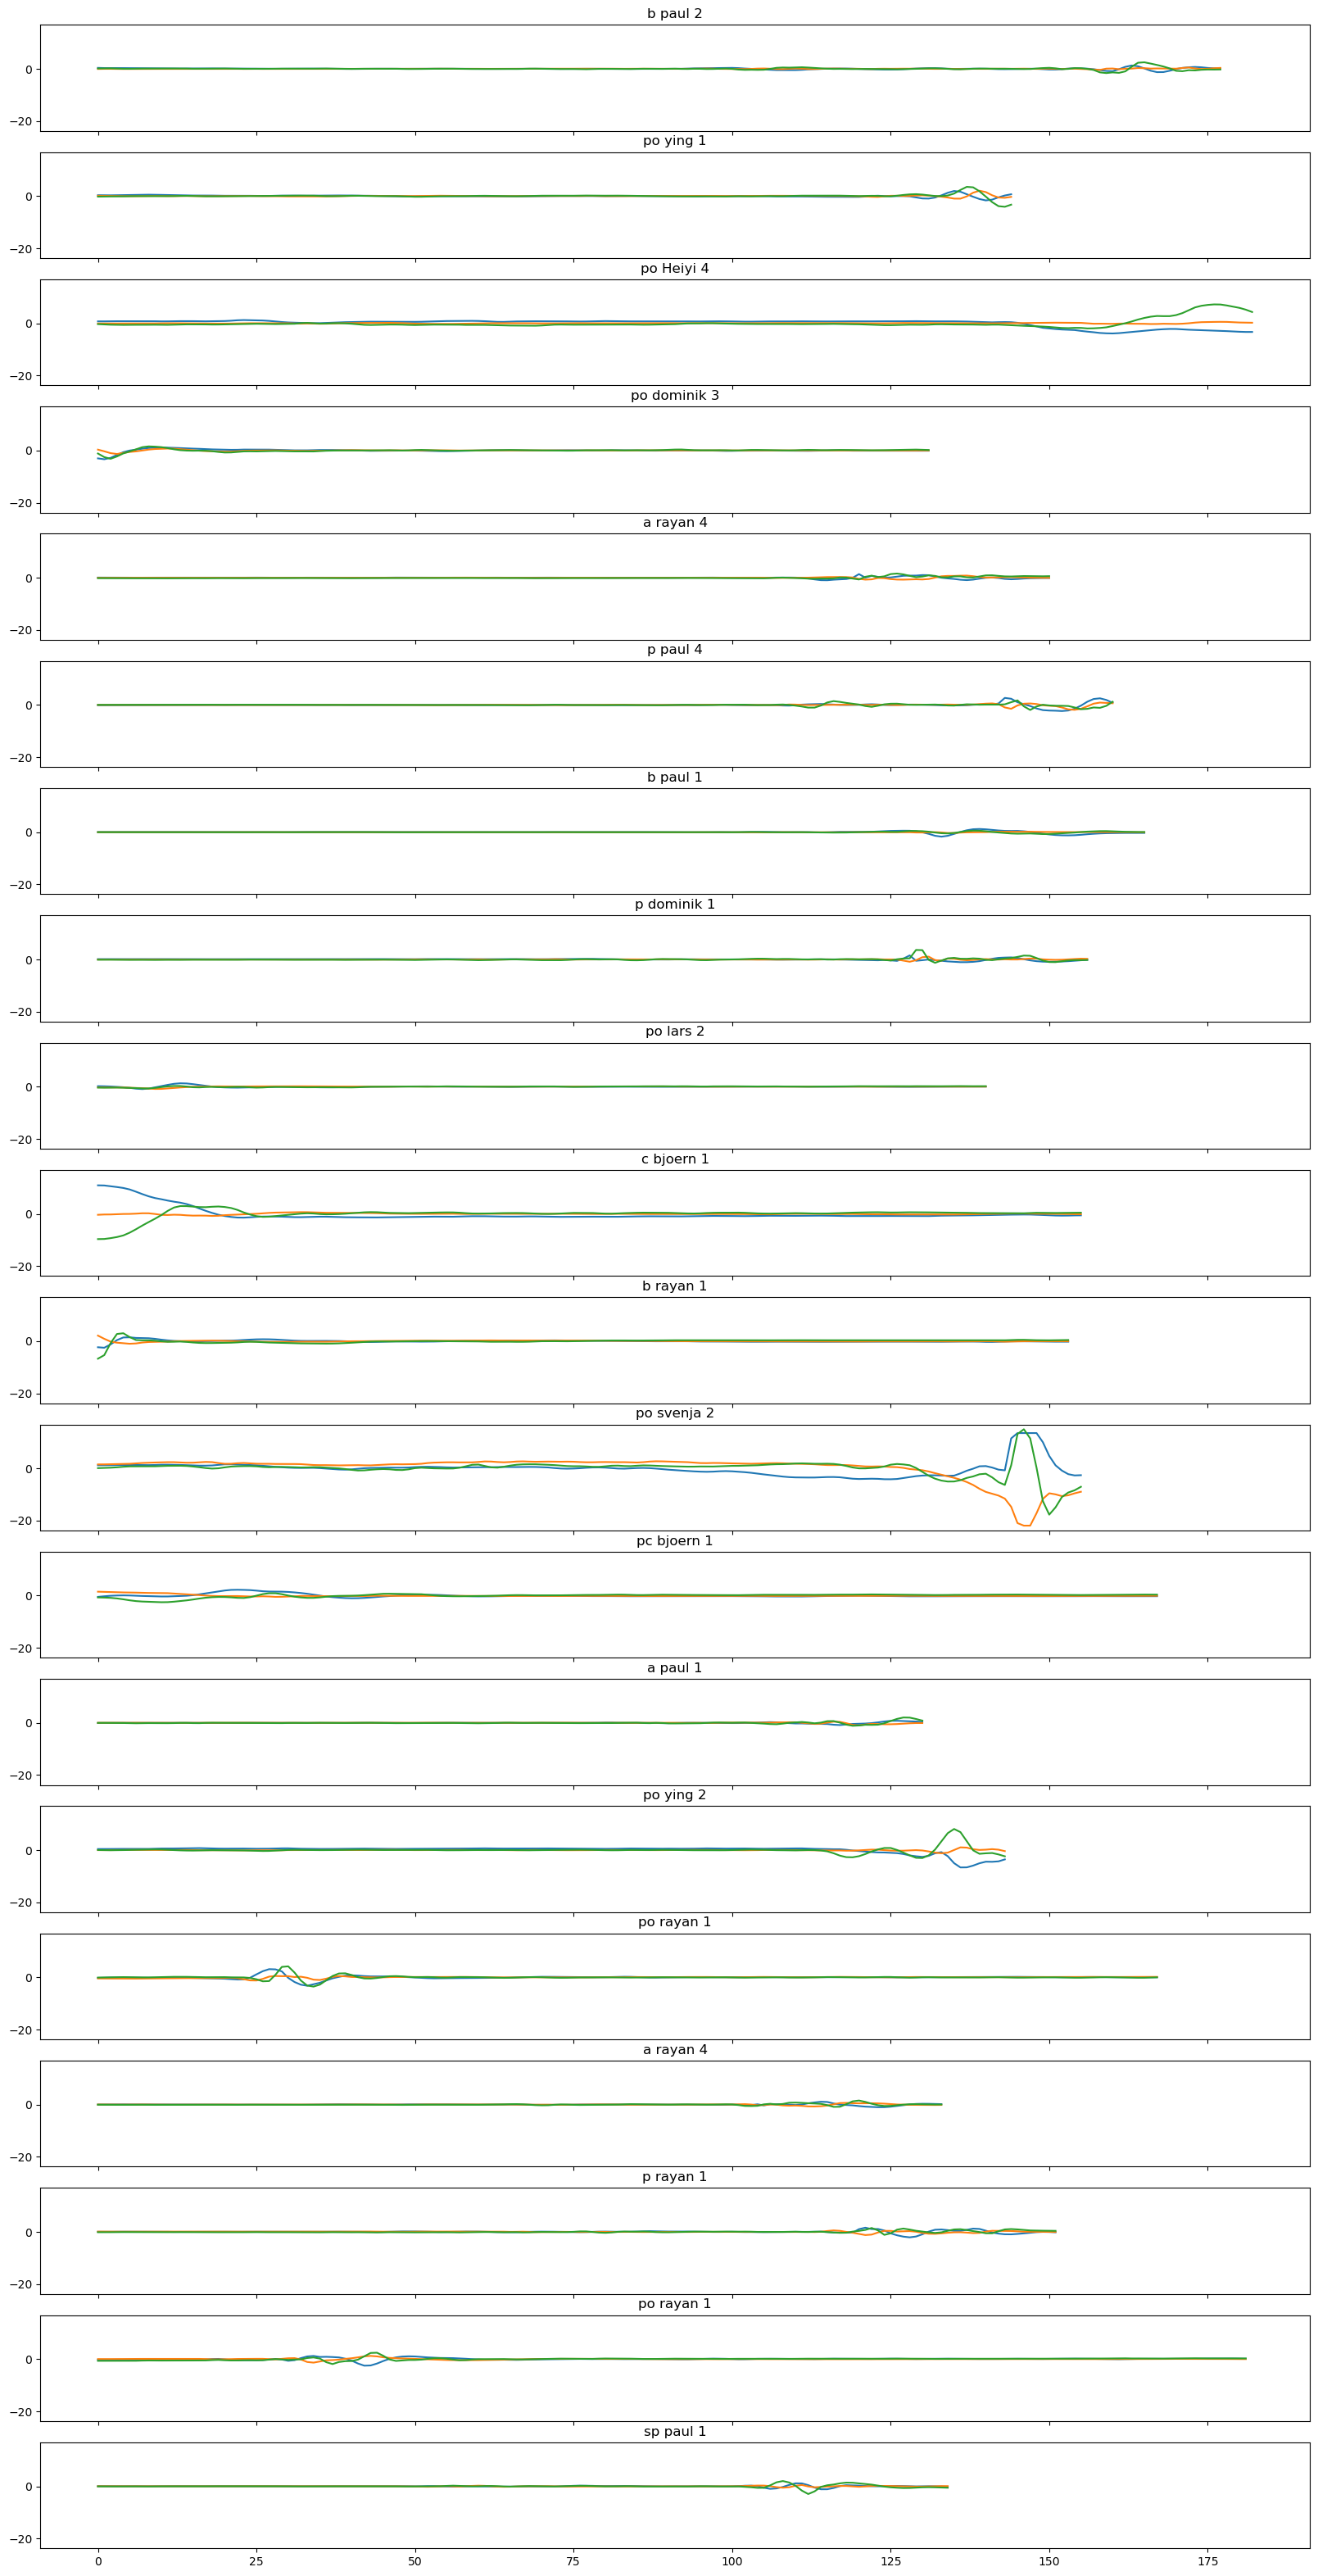

In [77]:
filtered_samples = sample_df[(~sample_df["label"].isin(["o", "pbd", "prr", "prl"]))]
filtered_samples["sort_value"] = filtered_samples["acc_centeredness"].abs() * filtered_samples["acc_abs_std"]
ids = filtered_samples.sort_values("sort_value", ascending=False).head(20)["id"]




fig, axes = plt.subplots(len(ids), 1, figsize=(20, 2*len(ids)), sharex=True, sharey=True)
for i, id_ in enumerate(ids):
    sample = samples[id_]
    axes[i].plot(sample["acc_z"] - sample["acc_z"].mean())
    axes[i].plot(sample["acc_x"] - sample["acc_x"].mean())
    axes[i].plot(sample["acc_y"] - sample["acc_y"].mean())
    sample
    axes[i].set_title(sample["label"] + " " + sample["participant"] + " " + sample["session"])

<Axes: xlabel='acc_centeredness_abs', ylabel='acc_std'>

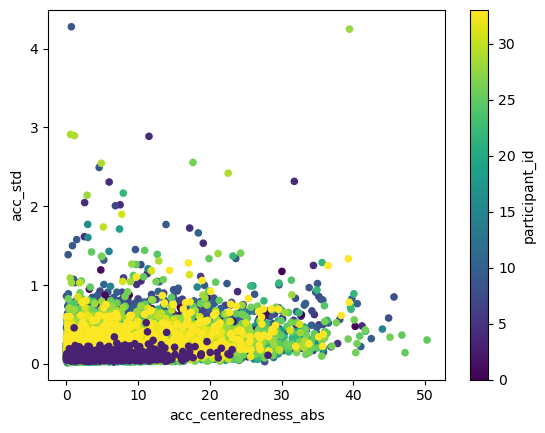

In [268]:
filtered_samples.plot.scatter(x="acc_centeredness_abs", y="acc_std", c="participant_id", colormap="viridis")

In [187]:
X = []
Y = []
for sample in samples:
    x = np.stack([sample["acc"], sample["gyro"]], axis=-1)
    y = (sample["label"], sample["participant"], sample["session"])
    X.append(x)
    Y.append(y)

In [196]:
n_clusters = 3

#kmeans = KernelKMeans(n_clusters=3, kernel="gak", n_init=100, random_state=0)
#kmeans = TimeSeriesKMeans(n_clusters=3, metric="dtw", n_init=1, random_state=0)
kmeans = KShape(n_clusters=3, n_init=1, random_state=0)
clusters = kmeans.fit_predict(X)


KeyboardInterrupt: 

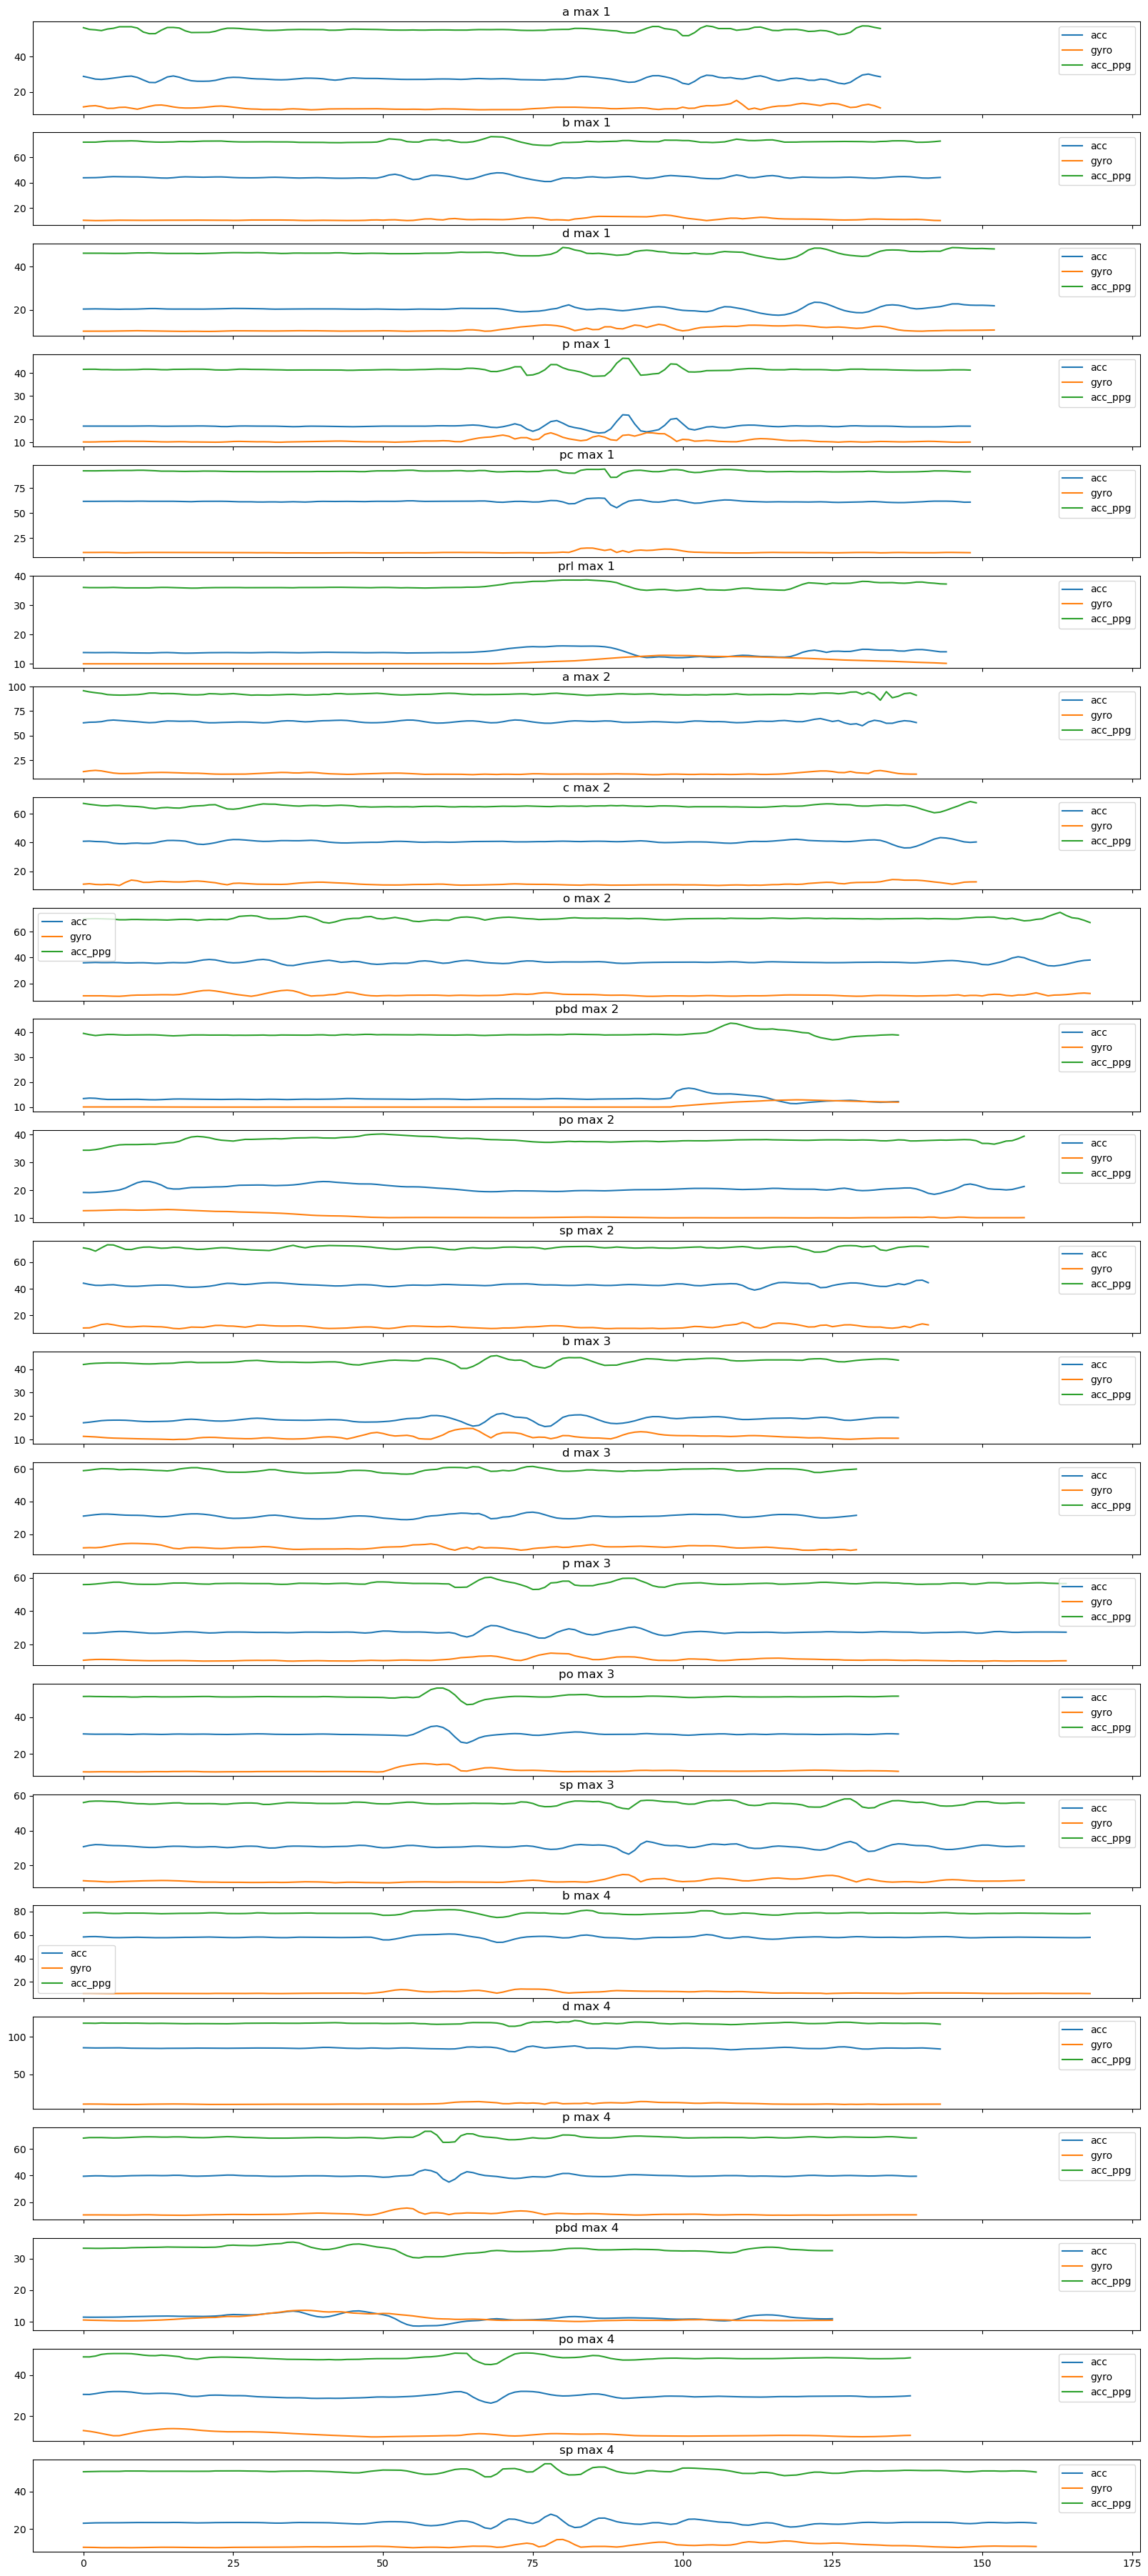

In [304]:
samples_max = []
for file in all_files:
    if "max" not in file:
        continue
    sample = import_hdf5_session(file, fixed_length=None)
    sample = compute_magnitudes(sample)
    samples_max += samplei

indices = list(range(0, len(samples_max), 30))
fig, axes = plt.subplots(len(indices), 1, figsize=(20, 2*len(indices)), sharex=True, sharey=False)
for k, i in enumerate(indices):
    axes[k].plot(samples_max[i]["acc"]/samples_max[i]["acc"].std(), label="acc")
    axes[k].plot(samples_max[i]["gyro"]/samples_max[i]["gyro"].std() + 10, label="gyro")
    axes[k].plot(samples_max[i]["acc_ppg"]/samples_max[i]["acc_ppg"].std() + 20, label="acc_ppg")
    axes[k].legend()
    axes[k].set_title(samples_max[i]["label"] + " " + samples_max[i]["participant"] + " " + samples_max[i]["session"])
    

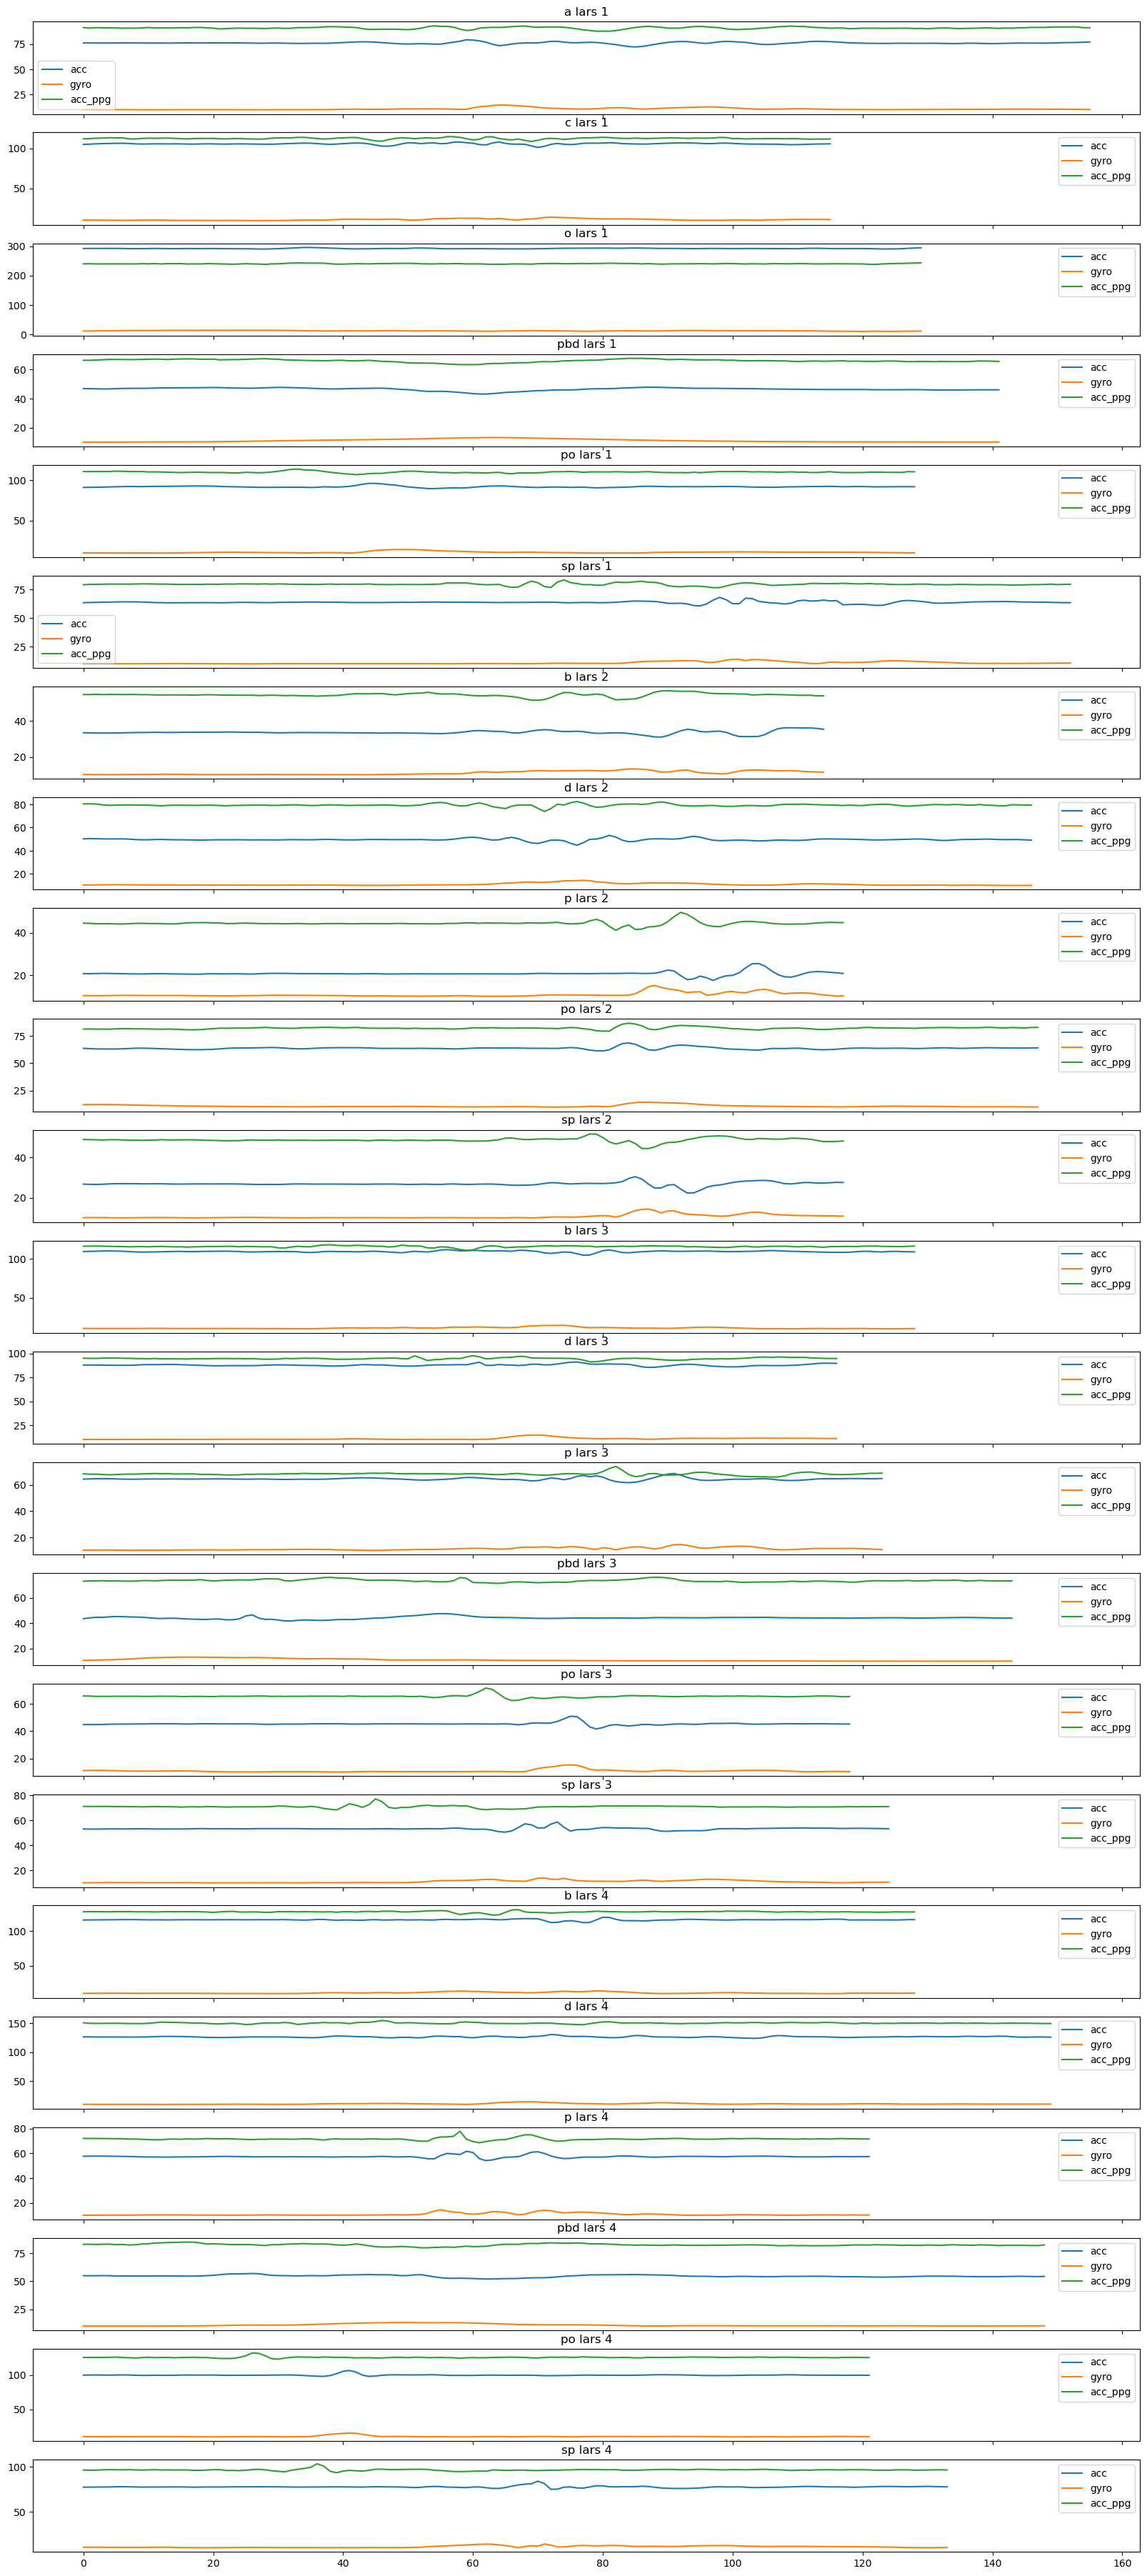

In [306]:
samples_max = []
for file in all_files:
    if "lars" not in file:
        continue
    sample = import_hdf5_session(file, fixed_length=None)
    sample = compute_magnitudes(sample)
    samples_max += sample

indices = list(range(0, len(samples_max), 30))
fig, axes = plt.subplots(len(indices), 1, figsize=(20, 2*len(indices)), sharex=True, sharey=False)
for k, i in enumerate(indices):
    axes[k].plot(samples_max[i]["acc"]/samples_max[i]["acc"].std(), label="acc")
    axes[k].plot(samples_max[i]["gyro"]/samples_max[i]["gyro"].std() + 10, label="gyro")
    axes[k].plot(samples_max[i]["acc_ppg"]/samples_max[i]["acc_ppg"].std() + 20, label="acc_ppg")
    axes[k].legend()
    axes[k].set_title(samples_max[i]["label"] + " " + samples_max[i]["participant"] + " " + samples_max[i]["session"])

In [349]:
samples = {}

for file in all_files:
    if "zhipeng" not in file.lower():
        continue
    print(file)
    sample = import_hdf5_session(file, fixed_length=None)
    samples[sample[0]["session"]] = sample

C:\Users\lhauptmann\Code\WristPPG2\data\dataset\participant_Zhipeng\participant_Zhipeng_1.hdf5
C:\Users\lhauptmann\Code\WristPPG2\data\dataset\participant_Zhipeng\participant_Zhipeng_2.hdf5
C:\Users\lhauptmann\Code\WristPPG2\data\dataset\participant_Zhipeng\participant_Zhipeng_3.hdf5
C:\Users\lhauptmann\Code\WristPPG2\data\dataset\participant_Zhipeng\participant_Zhipeng_4.hdf5


In [104]:

def normalize(signal):
    if signal.ndim == 1:
        return (signal - np.nanmean(signal)) / np.nanstd(signal)
    else: #ndim =2
        return (signal - np.nanmean(signal, axis=0, keepdims=True)) / np.nanstd(signal, axis=0, keepdims=True)

In [87]:
samples_session = samples["1"]
samples_labels = np.array([sample["label"] for sample in samples_session])


for label in np.unique(samples_labels):
    indices = np.where(samples_labels == label)[0]
    fig, axes = plt.subplots(len(indices), 1, figsize=(20, 2*len(indices)), sharex=True, sharey=False)
    for k, i in enumerate(indices):
        axes[k].plot(normalize(samples_session[i]["acc_z"]), label="acc_z")
        axes[k].plot(normalize(samples_session[i]["acc_x"]), label="acc_x")
        axes[k].plot(normalize(samples_session[i]["acc_y"]), label="acc_y")


        #axes[k].plot(samples_session[i]["acc_ppg_z"]/samples_session[i]["acc_ppg_z"].std() + 10, label="acc_ppg_z")
        #axes[k].plot(samples_session[i]["acc_ppg_x"]/samples_session[i]["acc_ppg_x"].std() + 10, label="acc_ppg_x")
        #axes[k].plot(samples_session[i]["acc_ppg_y"]/samples_session[i]["acc_ppg_y"].std() + 10, label="acc_ppg_y")
        axes[k].legend()
        axes[k].set_title(samples_session[i]["label"] + " " + samples_session[i]["participant"] + " " + samples_session[i]["session"])
    


NameError: name 'samples_labels' is not defined

In [140]:
file = [el for el in all_files if "mia" in el.lower()][0]
print(file)
sample = import_hdf5_sequences(file)

        

C:\Users\lhauptmann\Code\WristPPG2\data\dataset\participant_mia\participant_mia_2.hdf5


<Axes: >

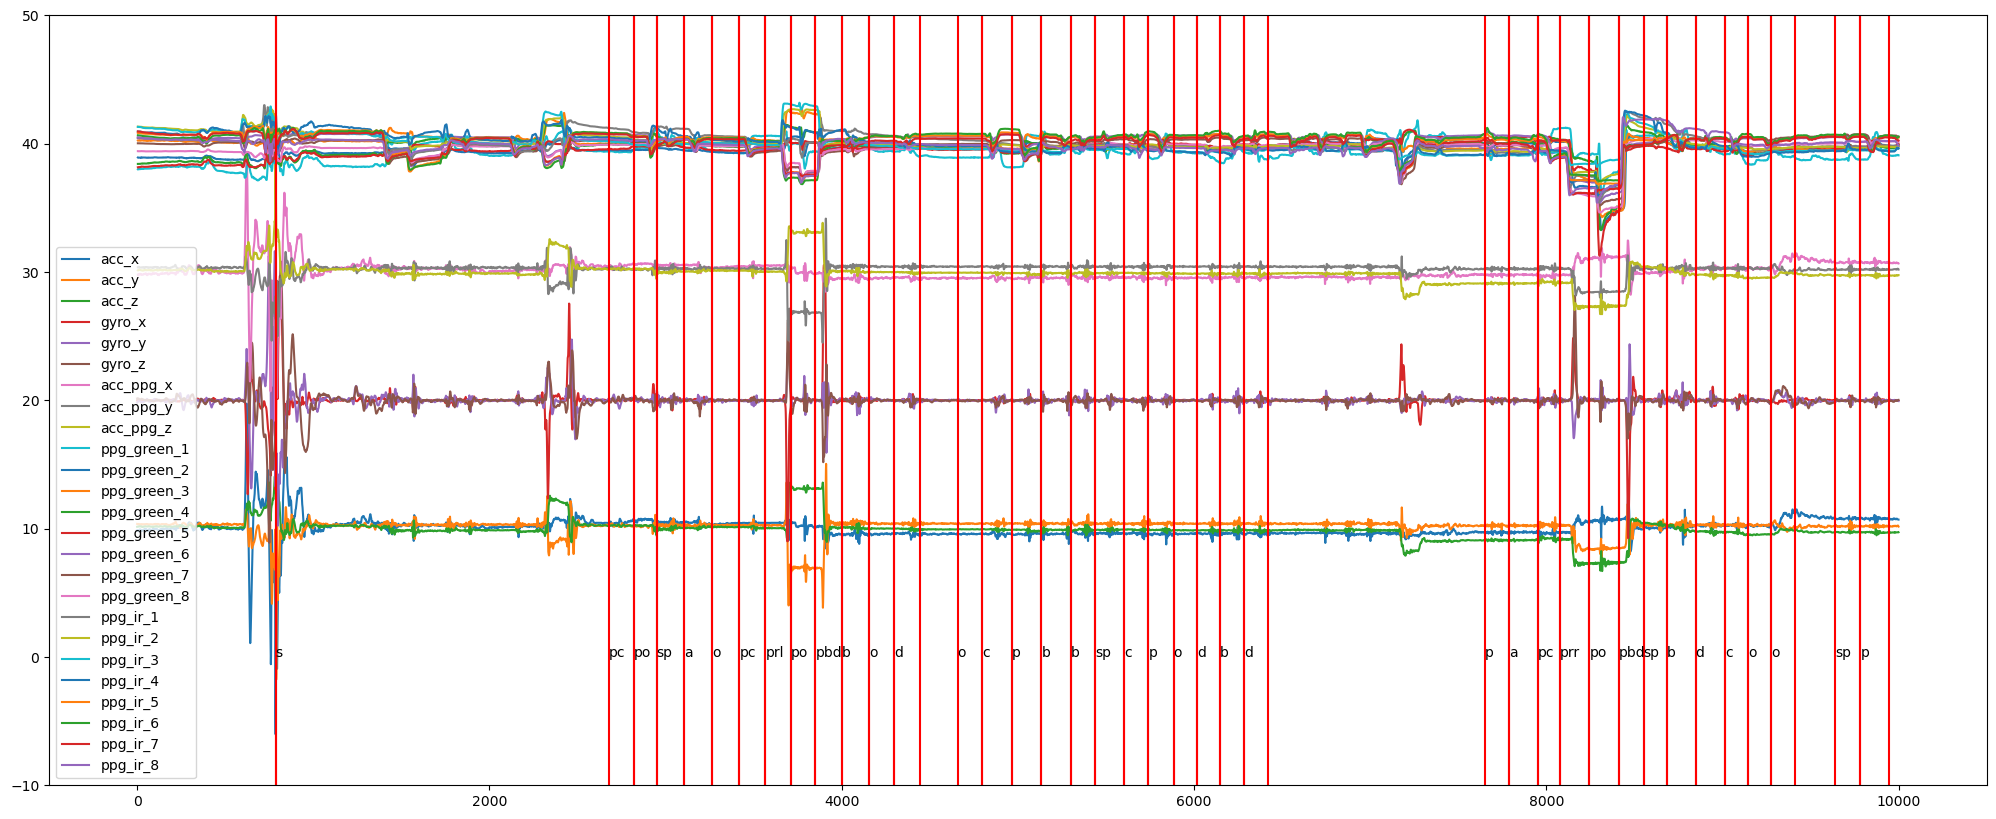

In [285]:
def normalize(signal):
    
    return (signal - np.nanmean(signal)) / np.nanstd(signal)

def plot_traces(sample, start_index, end_index, labels:np.array=None, label_times:np.array=None):

    
    fig, ax = plt.subplots(1, figsize=(25, 10))
    for acc in ["acc_x", "acc_y", "acc_z"]:
        ax.plot(normalize(sample[acc])[start_index:end_index] + 10, label=acc)
    for gyro in ["gyro_x", "gyro_y", "gyro_z"]:
        ax.plot(normalize(sample[gyro])[start_index:end_index]+20, label=gyro)
    for acc_ppg in ["acc_ppg_x", "acc_ppg_y", "acc_ppg_z"]:
        ax.plot(normalize(sample[acc_ppg])[start_index:end_index]+30, label=acc_ppg)
    for ppg in ["ppg_green_1", "ppg_green_2", "ppg_green_3", "ppg_green_4", "ppg_green_5", "ppg_green_6", "ppg_green_7", "ppg_green_8",\
                "ppg_ir_1", "ppg_ir_2", "ppg_ir_3", "ppg_ir_4", "ppg_ir_5", "ppg_ir_6", "ppg_ir_7", "ppg_ir_8",\
                ]:
        ax.plot(normalize(sample[ppg])[start_index:end_index]+40, label=ppg)
    ax.legend()
    ax.set_ylim(-10, 50)
    
    if labels is None:
        labels = sample["label"]
    if label_times is None:
        label_times = sample["label_indices"]
    
    for label_name, label_time in zip(labels, label_times):
        
        start_time, end_time = label_time
        if start_time < start_index or end_time > end_index:
            continue
        ax.axvline(start_time - start_index, color="red")
        ax.axvline(end_time - start_index, color="red")
        ax.text(start_time - start_index, 0, label_name)
    
    return ax
        
    
plot_traces(sample, start_index=0, end_index=10000)

In [126]:
samples = []
for file in all_files:
    sample = import_hdf5_session(file)
    samples.extend(sample)

In [127]:
acc_signals = [np.stack([sample["acc_x"], sample["acc_y"], sample["acc_z"]], axis=1) for sample in samples]

max_length = 170
acc_signals_padded = []
for signal in acc_signals:
    signal = normalize(signal)
    signal_length = signal.shape[0]
    if signal_length < max_length:
        pad_length = max_length - signal_length
        signal = np.pad(signal, ((pad_length//2, pad_length - pad_length//2), (0, 0)), "constant")
    elif signal_length > max_length:
        cut_length = signal_length - max_length
        signal = signal[cut_length//2:-cut_length//2, :]
    acc_signals_padded.append(signal)
acc_signals_padded = np.stack(acc_signals_padded)

In [129]:
from tslearn.clustering import TimeSeriesKMeans, KernelKMeans, KShape

model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=50, random_state=10, n_jobs=-1)
#model = KShape(n_clusters=3, n_init=50, random_state=0)
#model = KernelKMeans(n_clusters=3, kernel="gak", n_init=50, random_state=0)
clusters = model.fit_predict(acc_signals_padded)


print(clusters)

[1 1 1 ... 0 2 0]


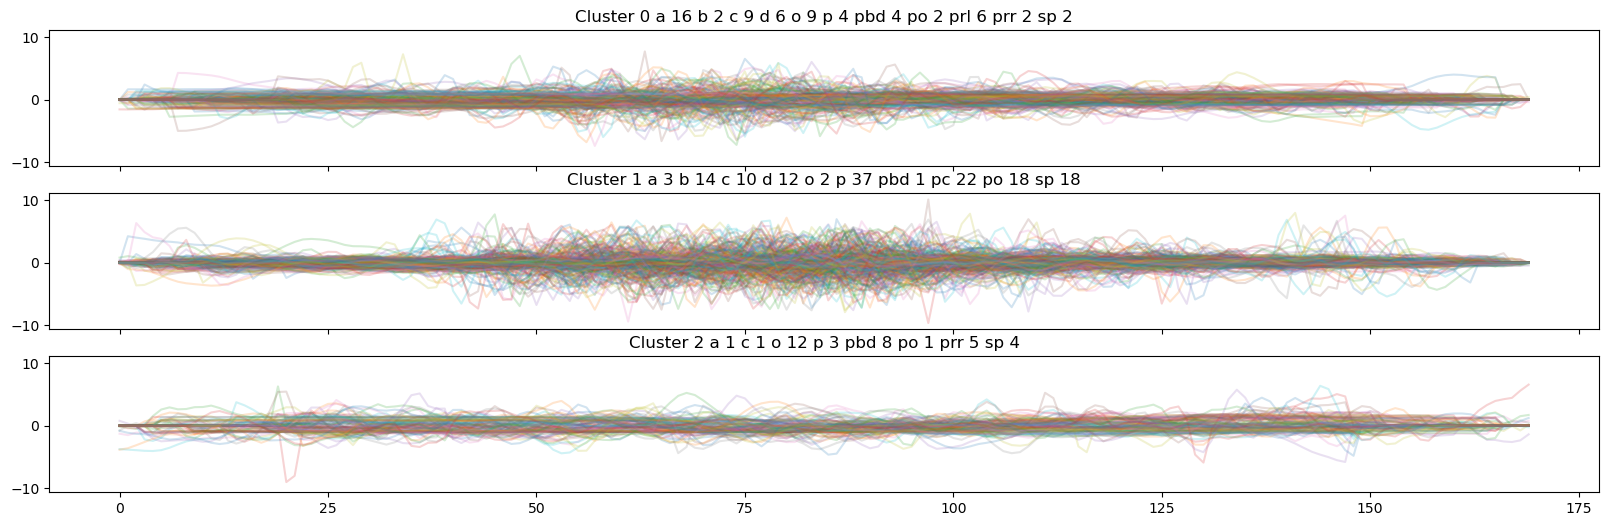

In [119]:
fig, axes = plt.subplots(3, 1, figsize=(20, 6), sharex=True, sharey=True)
for cluster in np.unique(clusters):
    indices = np.where(clusters == cluster)[0]
    labels, label_counts = np.unique([samples[i]["label"] for i in indices], return_counts=True)
    hist_str = " ".join([f"{label} {count}" for label, count in zip(labels, label_counts)])
    for i in indices:
        axes[cluster].plot(normalize(acc_signals_padded[i, :, :]), label=samples[i]["label"], alpha=0.2)

    axes[cluster].set_title(f"Cluster {cluster} {hist_str}")

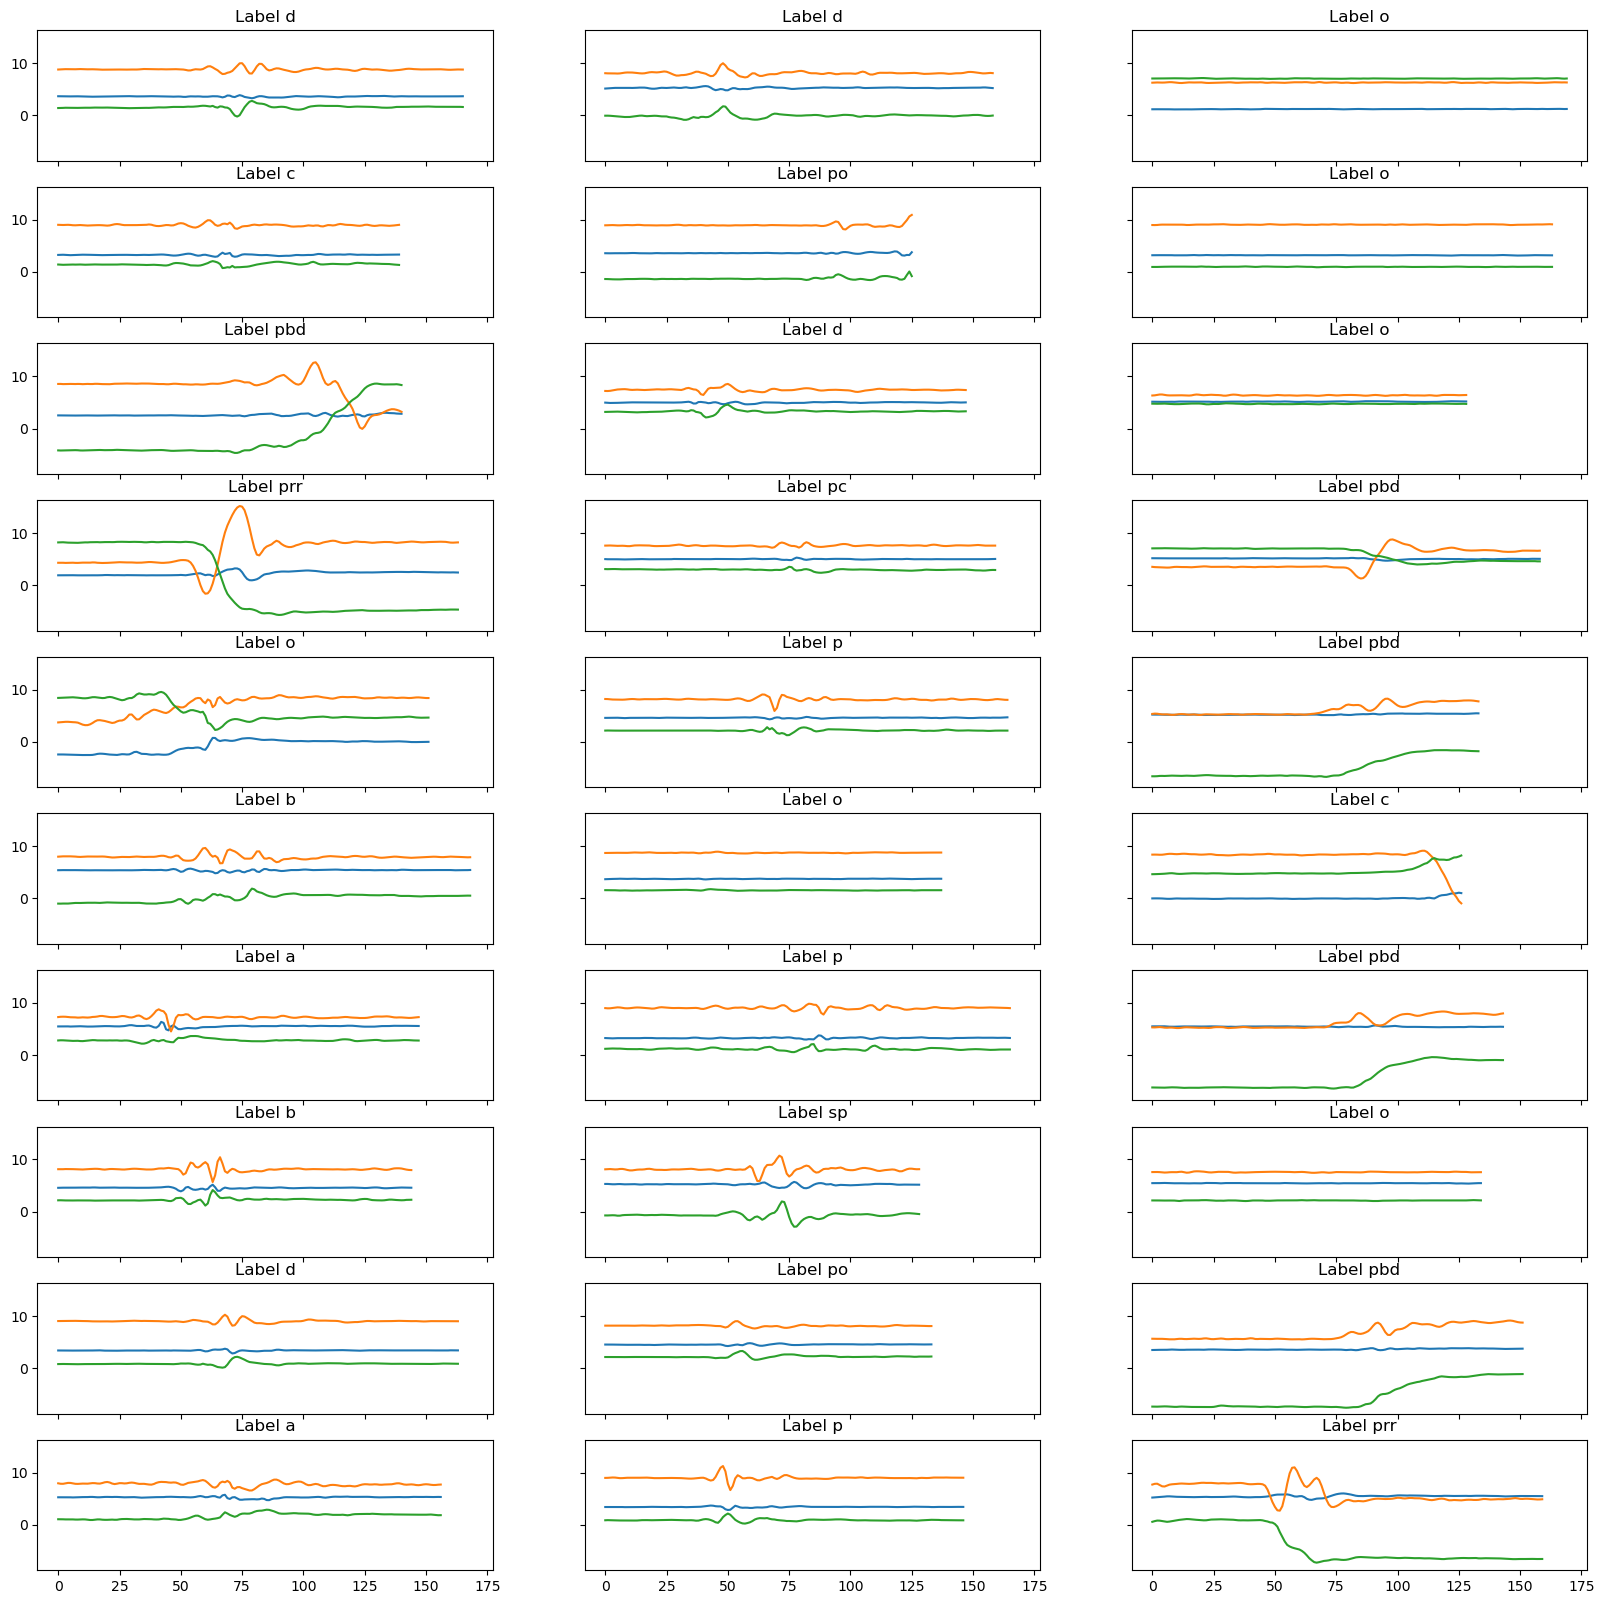

In [121]:
n_per_cluster = 10
fig, axes = plt.subplots(n_per_cluster, 3, figsize=(20, n_per_cluster*2), sharex=True, sharey=True)
for cluster in np.unique(clusters):
    indices = np.where(clusters == cluster)[0]
    np.random.shuffle(indices)
    for i in range(n_per_cluster):
        axes[i, cluster].plot(samples[indices[i]]["acc_x"], label=samples[indices[i]]["label"])
        axes[i, cluster].plot(samples[indices[i]]["acc_y"], label=samples[indices[i]]["label"])
        axes[i, cluster].plot(samples[indices[i]]["acc_z"], label=samples[indices[i]]["label"])
        axes[i, cluster].set_title(f"Label {samples[indices[i]]['label']}")


In [354]:
def correct_label_times(sample):

    label_times = np.array(sample["label_indices"])
    labels = np.array(sample["label"])

    def compute_energy(signals:list):
        return np.sum([(signal - np.nanmean(signal)) ** 2 for signal in signals], axis=0)

    def smooth_signal(signal, window_size=10):
        from scipy.ndimage import gaussian_filter1d
        return gaussian_filter1d(signal, window_size/2)

    def detect_peaks(signal):
        from scipy.signal import find_peaks, find_peaks_cwt
        peaks, _ = find_peaks(signal, distance=1, prominence=0.2)
        #peaks = find_peaks_cwt(signal, widths=np.arange(1, 10))
        return peaks

    def plot_peaks(peaks, signal, start_index, end_index, ax):
        for peak in peaks:
            if peak < start_index or peak > end_index:
                continue
            ax.plot(peak - start_index, signal[peak], "x", color="red")
        return ax

    signal_energy_gyro = compute_energy([sample["gyro_x"]/64, sample["gyro_y"]/16, sample["gyro_z"]/16])
    signal_energy_acc = compute_energy([sample["acc_x"]/1, sample["acc_y"]/1, sample["acc_z"]/1])
    signal_energy_ppg = compute_energy([sample["ppg_green_1"], sample["ppg_green_2"], sample["ppg_green_3"], sample["ppg_green_4"], sample["ppg_green_5"], sample["ppg_green_6"], sample["ppg_green_7"], sample["ppg_green_8"],\
                                        sample["ppg_ir_1"], sample["ppg_ir_2"], sample["ppg_ir_3"], sample["ppg_ir_4"], sample["ppg_ir_5"], sample["ppg_ir_6"], sample["ppg_ir_7"], sample["ppg_ir_8"]])
    #gaussian smoothing
    signal_energy_gyro = smooth_signal(signal_energy_gyro, window_size=15)
    signal_energy_acc = smooth_signal(signal_energy_acc, window_size=15)
    signal_energy_ppg = smooth_signal(signal_energy_ppg/2000000)
    signal_energy = signal_energy_gyro + signal_energy_acc
    #signal_energy = np.abs(np.diff(signal_energy))*16
    signal_energy_peaks = detect_peaks(signal_energy)


    argsort = np.argsort(label_times[:, 0])
    labels = labels[argsort]
    label_times = label_times[argsort]

    gesture_start, gesture_end = 100, 140

    gestures_start, gestures_end,  = label_times[gesture_start, 0], label_times[gesture_end, 1]


    all_shifts = {}

    prev_shift = 0
    for i, (label_start, label_end) in enumerate(label_times):
        #print(label_start, label_end)
        label_peaks = signal_energy_peaks[(signal_energy_peaks > label_start) & (signal_energy_peaks < label_end)]
        
        if len(label_peaks) == 0 or labels[i] in ["o", "pbd"]:
            shift = 0
        else:
            peaks_sizes = signal_energy[label_peaks]
            largest_peak = label_peaks[np.argmax(peaks_sizes)]
            
            shift = largest_peak - (label_start + label_end) / 2
        label_times[i, 0] += (shift + prev_shift)/2
        label_times[i, 1] += (shift + prev_shift)/2
        prev_shift = shift
        all_shifts[i] = shift


    #ax = plot_traces(sample, gestures_start, gestures_end, labels, label_times)
    #ax.plot(signal_energy[gestures_start:gestures_end] + 50, label="energy")
    #ax.plot(signal_energy_ppg[gestures_start:gestures_end] + 60, label="energy")


    #plot_peaks(signal_energy_peaks, signal_energy+50, gestures_start, gestures_end, ax)

    #ax.set_ylim(-10, 60)
    shift_mean = np.mean(list(all_shifts.values()))
    shift_std = np.std(list(all_shifts.values()))
    print(f"Mean shift: {shift_mean} Std shift: {shift_std}")
    print(all_shifts)
    sample["label_indices"] = label_times.tolist()
    
    return sample, list(all_shifts.values())


all_shifts = []
for file in all_files:
    sample = import_hdf5_sequences(file)
    sample, shifts = correct_label_times(sample)
    all_shifts.extend(shifts)
    save_file = file.replace("dataset", "dataset_corrected")
    os.makedirs(os.path.dirname(save_file), exist_ok=True)
    save_hd5f_sequence(save_file, sample, overwrite=True)



Mean shift: 3.791208791208791 Std shift: 24.466363162056833
{0: 0, 1: -41.0, 2: 49.0, 3: 11.5, 4: -15.0, 5: 18.0, 6: 12.0, 7: -4.0, 8: 31.5, 9: 18.5, 10: 29.5, 11: 61.5, 12: 51.0, 13: 10.5, 14: 22.0, 15: -34.0, 16: 6.0, 17: -17.0, 18: 49.5, 19: 2.5, 20: -5.0, 21: 45.0, 22: 33.0, 23: 36.5, 24: -5.0, 25: 55.0, 26: 15.5, 27: -10.5, 28: -22.0, 29: 13.0, 30: -1.0, 31: 0.0, 32: -14.0, 33: 4.5, 34: 19.0, 35: 25.5, 36: -10.5, 37: -12.0, 38: -60.0, 39: -75.5, 40: 66.5, 41: -15.0, 42: -7.5, 43: -24.0, 44: -2.5, 45: 50.0, 46: 42.5, 47: -43.0, 48: 43.5, 49: 31.5, 50: -57.5, 51: -44.0, 52: -6.0, 53: -13.0, 54: -19.5, 55: -6.5, 56: 5.5, 57: -1.0, 58: 12.5, 59: 72.0, 60: 62.0, 61: 20.0, 62: 65.0, 63: -29.5, 64: 64.0, 65: 62.5, 66: -63.5, 67: -40.5, 68: -3.5, 69: -27.0, 70: 17.0, 71: 22.0, 72: 1.5, 73: 54.5, 74: 21.5, 75: 9.5, 76: 36.0, 77: 14.5, 78: 15.0, 79: 0, 80: 33.5, 81: 8.5, 82: 28.0, 83: 28.5, 84: 7.0, 85: 5.0, 86: 0, 87: 10.5, 88: 17.0, 89: -46.0, 90: -1.0, 91: 0, 92: 0, 93: -66.0, 94: 9.5, 9

(array([1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00,
        7.000e+00, 9.000e+00, 1.100e+01, 1.800e+01, 1.400e+01, 2.300e+01,
        3.900e+01, 2.000e+01, 3.700e+01, 4.200e+01, 4.400e+01, 4.400e+01,
        4.000e+01, 3.500e+01, 6.800e+01, 3.400e+01, 6.000e+01, 4.700e+01,
        5.500e+01, 6.500e+01, 5.200e+01, 6.800e+01, 6.300e+01, 8.700e+01,
        7.400e+01, 1.110e+02, 9.900e+01, 1.440e+02, 1.250e+02, 2.280e+02,
        2.050e+02, 2.980e+02, 3.370e+02, 2.850e+02, 4.450e+02, 3.710e+02,
        5.690e+02, 4.940e+02, 6.620e+02, 4.480e+02, 7.170e+02, 5.440e+02,
        8.210e+02, 6.850e+02, 8.510e+02, 8.830e+02, 5.492e+03, 8.630e+02,
        6.180e+02, 7.770e+02, 5.790e+02, 7.010e+02, 4.580e+02, 5.800e+02,
        4.200e+02, 4.700e+02, 4.180e+02, 3.000e+02, 3.590e+02, 2.620e+02,
        2.570e+02, 2.130e+02, 2.130e+02, 1.550e+02, 1.720e+02, 1.100e+02,
        1.520e+02, 8.700e+01, 1.210e+02, 9.900e+01, 7.800e+01, 8.600e+01,
        5.700e+01, 5.600e+01, 5.500e+0

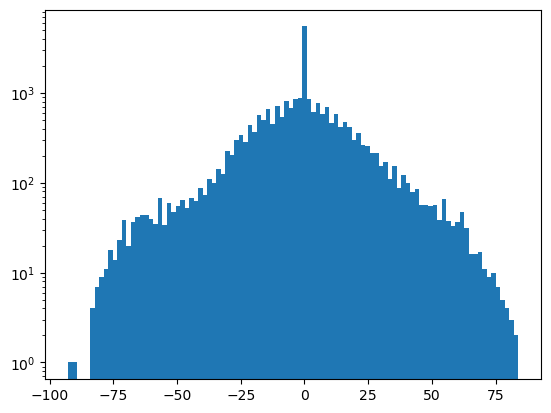

In [355]:
plt.hist(all_shifts, bins=100, log=True)

In [353]:
len(all_shifts)

143

In [41]:
data = import_hdf5_sequences(r"C:\Users\lhauptmann\Code\WristPPG2\data\dataset\participant_miyuki\participant_miyuki_1.hdf5")

In [23]:
labels

array(['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b',
       'b', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c',
       'c', 'c', 'c', 'c', 'c', 'c', 'd', 'd', 'd', 'd', 'd', 'd', 'd',
       'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'o', 'o', 'o', 'o', 'o',
       'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
       'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
       'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
       'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
       'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
       'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
       'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
       'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
       'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o

In [30]:
data["acc_x"].shape

(35669,)

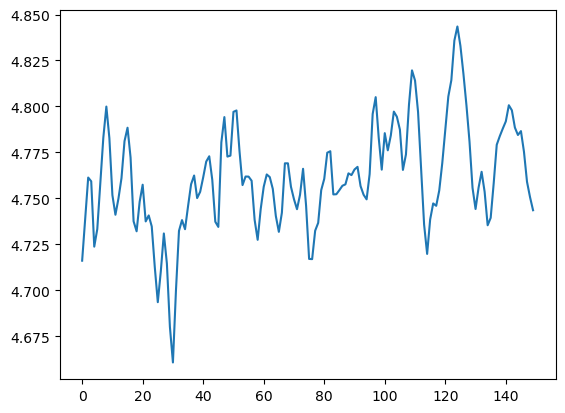

In [33]:
indices = data["label_indices"][np.where(label_length == 0)[0][0]]
plt.plot(data["acc_x"][indices[0]:indices[1]])

In [40]:
data_path = r"C:\Users\lhauptmann\Code\WristPPG2\data\dataset"
for participant in os.listdir(data_path):
    participant_path = os.path.join(data_path, participant)
    for file in os.listdir(participant_path):
        if "corrected" in file or not file.endswith(".hdf5"):
            continue
        print(file)
        
        with h5py.File(os.path.join(participant_path, file), 'r+') as f:
            data_dict = f
            
            for key in data_dict.keys():
                
                if key == "data":
                    continue
                start_time = f[key]["start_time"][()]
                end_time = f[key]["end_time"][()]
                label = f[key]["label"][()]
                if end_time == start_time and label == "o":
                    print(f"Correcting {key}")
                    end_time = start_time + 150/112.3
                    f[key]["end_time"][()] = end_time

participant_alex_1.hdf5
participant_alex_2.hdf5
participant_alex_3.hdf5
participant_alex_4.hdf5
participant_amran_1.hdf5
participant_amran_2.hdf5
participant_amran_3.hdf5
participant_amran_4.hdf5
participant_annamalai_1.hdf5
participant_annamalai_2.hdf5
participant_annamalai_3.hdf5
participant_annamalai_4.hdf5
participant_antonia_1.hdf5
participant_antonia_2.hdf5
participant_antonia_4.hdf5
participant_anusha_1.hdf5
participant_anusha_2.hdf5
participant_anusha_3.hdf5
participant_anusha_4.hdf5
participant_ariane_1.hdf5
participant_ariane_2.hdf5
participant_ariane_3.hdf5
participant_ariane_4.hdf5
participant_athena_1.hdf5
participant_athena_2.hdf5
participant_athena_3.hdf5
participant_athena_4.hdf5
participant_ben_1.hdf5
participant_ben_2.hdf5
participant_ben_3.hdf5
participant_berken_1.hdf5
participant_berken_2.hdf5
participant_berken_3.hdf5
participant_berken_4.hdf5
participant_bjoern_1.hdf5
participant_bjoern_2.hdf5
participant_bjoern_3.hdf5
participant_bjoern_4.hdf5
participant_blaise

(array([147.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          3.,   0.,   3.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   1.,
          1.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.]),
 array([0.        , 0.01518307, 0.03036613, 0.0455492 , 0.06073227,
        0.07591534, 0.0910984 , 0.10628147, 0.12146454, 0.13664761,
        0.15183067, 0.16701374, 0.18219681, 0.19737988, 0.21256294,
        0.22774601, 0.24292908, 0.25811214, 0.27329521, 0.28847828,
        0.30366135, 0.31884441, 0.33402748, 0.

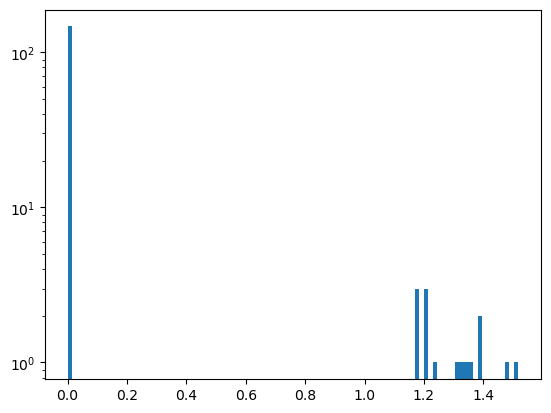

In [24]:
label_length = np.array([el[1] - el[0] for el in data["label_times"]])
labels = np.array(data["label"])
plt.hist(label_length[labels == "o"], log=True, bins=100)

[(1733241929.3177485, 1733241930.5149598),
 (1733241932.017263, 1733241933.2615151),
 (1733241958.3539872, 1733241959.662394),
 (1733241960.9235535, 1733241962.1928144),
 (1733241962.1938138, 1733241963.581098),
 (1733241967.8664064, 1733241969.131393),
 (1733241977.3279624, 1733241978.620348),
 (1733242004.7754474, 1733242005.979692),
 (1733242008.4645944, 1733242009.6058288),
 (1733242028.2605944, 1733242029.7018905),
 (1733242029.7028904, 1733242031.0341644),
 (1733242031.0351644, 1733242032.1653957),
 (1733242032.1663957, 1733242033.3016286),
 (1733242075.0712762, 1733242076.2275147),
 (1733242082.5647287, 1733242084.0500355),
 (1733241873.0945125, 1733241874.2542229),
 (1733241874.2542229, 1733241875.7153163),
 (1733241892.3848815, 1733241893.8521786),
 (1733241901.9621491, 1733241903.1033826),
 (1733241920.9377966, 1733241922.0872273),
 (1733241937.5056815, 1733241938.9079657),
 (1733241963.5820975, 1733241964.9953861),
 (1733241974.404467, 1733241975.8786678),
 (1733241999.18023